In [13]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

class BalancedMixUp:
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, x_instance, y_instance, x_class, y_class):
        # ベータ分布からλをサンプリング
        lam = torch.distributions.beta.Beta(self.alpha, 1).sample()
        lam = lam.to(x_instance.device)
        print(lam)

        # 新しい合成サンプルを生成
        # x_mixed = lam * x_instance + (1 - lam) * x_class
        # y_mixed = lam * y_instance + (1 - lam) * y_class
        x_mixed = lam * x_class + (1 - lam) * x_instance
        y_mixed = lam * y_class + (1 - lam) * y_instance

        return x_mixed, y_mixed

def get_class_based_sampler(dataset, labels):
    # 各クラスの頻度を計算
    class_counts = torch.bincount(labels)
    num_samples = len(labels)

    # 各クラスのサンプリング確率を計算
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[labels]

    # サンプリング用のWeightedRandomSamplerを作成
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)
    return sampler

# ダミーデータセット
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]


In [ ]:

# データとラベルの準備
num_classes = 2
pos_ratio = 0.05
neg_count = int(1024*(1-pos_ratio))
pos_count = 1024 - neg_count
num_samples_per_class = [neg_count, pos_count]  # 不均衡なサンプル数
data = []
labels = []

for i, num_samples in enumerate(num_samples_per_class):
    data.append(torch.randn(num_samples, 3, 32, 32))
    labels.append(torch.full((num_samples,), i))

data = torch.cat(data)
labels = torch.cat(labels)

# インスタンスベースのデータローダー
dataset = CustomDataset(data, labels)
instance_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# クラスベースのサンプリングによるデータローダー
class_sampler = get_class_based_sampler(dataset, labels)
class_loader = DataLoader(dataset, batch_size=64, sampler=class_sampler)

# Balanced MixUpの適用
mixup = BalancedMixUp(alpha=0.2)

# トレーニングループでの使用例
for (x_instance, y_instance), (x_class, y_class) in zip(instance_loader, class_loader):
    x_mixed, y_mixed = mixup(x_instance, y_instance, x_class, y_class)

    # モデルへの入力として使用
    # output = model(x_mixed)
    # loss = criterion(output, y_mixed)
    # loss.backward()
    # optimizer.step()

    print(f"x_mixed shape: {x_mixed.shape}, y_mixed shape: {y_mixed.shape}")

tensor(0.0210)
x_mixed shape: torch.Size([64, 3, 32, 32]), y_mixed shape: torch.Size([64])
tensor(0.0002)
x_mixed shape: torch.Size([64, 3, 32, 32]), y_mixed shape: torch.Size([64])
tensor(0.0021)
x_mixed shape: torch.Size([64, 3, 32, 32]), y_mixed shape: torch.Size([64])
tensor(0.7771)
x_mixed shape: torch.Size([64, 3, 32, 32]), y_mixed shape: torch.Size([64])
tensor(4.4645e-05)
x_mixed shape: torch.Size([64, 3, 32, 32]), y_mixed shape: torch.Size([64])
tensor(5.7154e-05)
x_mixed shape: torch.Size([64, 3, 32, 32]), y_mixed shape: torch.Size([64])
tensor(0.0002)
x_mixed shape: torch.Size([64, 3, 32, 32]), y_mixed shape: torch.Size([64])
tensor(0.9691)
x_mixed shape: torch.Size([64, 3, 32, 32]), y_mixed shape: torch.Size([64])
tensor(0.0615)
x_mixed shape: torch.Size([64, 3, 32, 32]), y_mixed shape: torch.Size([64])
tensor(0.0186)
x_mixed shape: torch.Size([64, 3, 32, 32]), y_mixed shape: torch.Size([64])
tensor(0.0241)
x_mixed shape: torch.Size([64, 3, 32, 32]), y_mixed shape: torch.Si

In [15]:
y_mixed.squeeze()

tensor([0.0000e+00, 3.2914e-04, 3.2914e-04, 3.2914e-04, 3.2914e-04, 3.2914e-04,
        3.2914e-04, 3.2914e-04, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        3.2914e-04, 0.0000e+00, 3.2914e-04, 3.2914e-04, 3.2914e-04, 0.0000e+00,
        3.2914e-04, 0.0000e+00, 0.0000e+00, 3.2914e-04, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.2914e-04, 3.2914e-04, 0.0000e+00, 3.2914e-04,
        3.2914e-04, 3.2914e-04, 3.2914e-04, 3.2914e-04, 3.2914e-04, 9.9967e-01,
        0.0000e+00, 3.2914e-04, 0.0000e+00, 3.2914e-04, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 3.2914e-04, 0.0000e+00, 3.2914e-04, 3.2914e-04, 0.0000e+00,
        0.0000e+00, 3.2914e-04, 1.0000e+00, 3.2914e-04, 3.2914e-04, 3.2914e-04,
        3.2914e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 3.2914e-04])

In [16]:
y_instance.squeeze()

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [17]:
y_class.squeeze()

tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1])

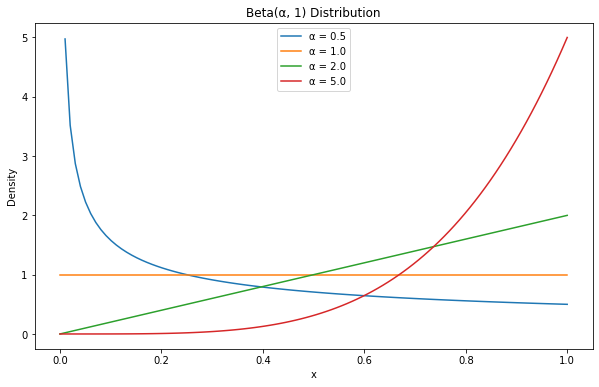

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# αの異なる値を設定
alpha_values = [0.5, 1.0, 2.0, 5.0]
x = np.linspace(0, 1, 100)

# 各αに対するBeta(α, 1)の分布をプロット
plt.figure(figsize=(10, 6))
for alpha in alpha_values:
    y = beta.pdf(x, alpha, 1)
    plt.plot(x, y, label=f'α = {alpha}')

plt.title('Beta(α, 1) Distribution')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()